# Imports

In [17]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader as web

from scipy import stats 

plt.style.use('fivethirtyeight')

STOCK_SYMBOL = 'TCF'
START_DATE = '1990-01-01'
END_DATE = '2021-02-28'
DATA_SOURCE = 'yahoo'

def get_prediction_interval(y_test, test_predictions, pi=.95):
    '''
    Get a prediction interval for a linear regression.
    Code from: https://github.com/NathanMaton/prediction_intervals
    
    INPUTS: 
        - Single prediction, 
        - y_test
        - All test set predictions,
        - Prediction interval threshold (default = .95) 
    OUTPUT: 
        - Prediction interval for single prediction
    '''
    
    #get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)

    #get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev
    
    return interval

#     #generate prediction interval lower and upper bound
#     lower, upper = test_predictions - interval, test_predictions + interval

#     return lower, test_predictions, upper

# Read Data

In [11]:
df = web.DataReader(STOCK_SYMBOL, data_source=DATA_SOURCE, start=START_DATE, end=END_DATE)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1990-01-02,8.465004,8.465004,0.000000,8.465004,1187.0,3.104571
1990-01-03,8.401833,8.338661,0.000000,8.338661,3562.0,3.058237
1990-01-04,8.465004,8.465004,0.000000,8.465004,396.0,3.104571
1990-01-05,8.338661,8.022803,0.000000,8.338661,1979.0,3.058237
1990-01-08,8.338661,8.338661,8.338661,8.338661,0.0,3.058237
...,...,...,...,...,...,...
2021-02-22,45.889999,44.419998,44.419998,45.580002,1111100.0,45.580002
2021-02-23,46.099998,45.320000,45.650002,45.980000,1178100.0,45.980000
2021-02-24,47.630001,46.200001,46.250000,47.410000,1349500.0,47.410000


In [12]:
df.reset_index(inplace=True)
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,7850.000000,7850.000000,7850.000000,7850.000000,7.850000e+03,7850.000000
mean,26.916341,26.143368,26.235001,26.552817,1.311366e+05,17.647799
std,10.769851,10.533046,11.270572,10.652054,3.431162e+05,11.600003
min,6.569854,6.569854,0.000000,6.569854,0.000000e+00,2.466665
25%,20.809999,20.137040,20.500000,20.490000,4.883000e+03,9.885625
50%,25.760872,24.865623,25.299050,25.343535,3.431750e+04,14.909022
75%,31.807499,30.819762,31.340000,31.377500,9.747500e+04,20.888193
max,59.830002,58.580002,59.669998,59.180000,1.289740e+07,53.248344


In [13]:
corr = df.corr(method='pearson')

corr.style.background_gradient(cmap='RdBu').set_precision(2)

,High,Low,Open,Close,Volume,Adj Close
High,1.00,1.00,0.99,1.00,0.37,0.93
Low,1.00,1.00,0.99,1.00,0.36,0.93
Open,0.99,0.99,1.00,0.99,0.36,0.92
Close,1.00,1.00,0.99,1.00,0.37,0.93
Volume,0.37,0.36,0.36,0.37,1.00,0.48
Adj Close,0.93,0.93,0.92,0.93,0.48,1.00


In [41]:
new_df = df.copy()
new_df['Year']=df['Date'].dt.year
new_df['Month']=df['Date'].dt.month
new_df['Day']=df['Date'].dt.day

new_df=new_df[['Date','Day','Month','Year','High','Open','Low','Close']]

atributes = ['Day','Month','Year','High','Open','Low']
target = ['Close']

train_df = new_df[new_df['Year'] <= 2018]
test_df = new_df[new_df['Year'] > 2018]

lr_model=LinearRegression()
lr_model.fit(train_df[atributes], train_df[target])
test_pred = lr_model.predict(test_df[atributes])

new_df['prediciton'] = lr_model.predict(new_df[atributes])

interval = get_prediction_interval(new_df[new_df['Year'] > 2018]['Close'].to_numpy(), new_df[new_df['Year'] > 2018]['prediciton'].to_numpy())

new_df['upper'] =  new_df['prediciton'] + interval
new_df['lower'] =  new_df['prediciton'] - interval

new_df

,Date,Day,Month,Year,High,Open,Low,Close,prediciton,upper,lower
0,1990-01-02,2,1,1990,8.465004,0.000000,8.465004,8.465004,8.613272,9.578457,7.648087
1,1990-01-03,3,1,1990,8.401833,0.000000,8.338661,8.338661,8.522890,9.488076,7.557705
2,1990-01-04,4,1,1990,8.465004,0.000000,8.465004,8.465004,8.614019,9.579205,7.648834
3,1990-01-05,5,1,1990,8.338661,0.000000,8.022803,8.338661,8.354441,9.319626,7.389256
4,1990-01-08,8,1,1990,8.338661,8.338661,8.338661,8.338661,8.285739,9.250924,7.320554
...,...,...,...,...,...,...,...,...,...,...,...
7845,2021-02-22,22,2,2021,45.889999,44.419998,44.419998,45.580002,45.230703,46.195889,44.265518
7846,2021-02-23,23,2,2021,46.099998,45.650002,45.320000,45.980000,45.701866,46.667051,44.736680
7847,2021-02-24,24,2,2021,47.630001,46.250000,46.200001,47.410000,46.983567,47.948752,46.018382
7848,2021-02-25,25,2,2021,48.160000,48.130001,45.750000,45.930000,47.075147,48.040332,46.109961


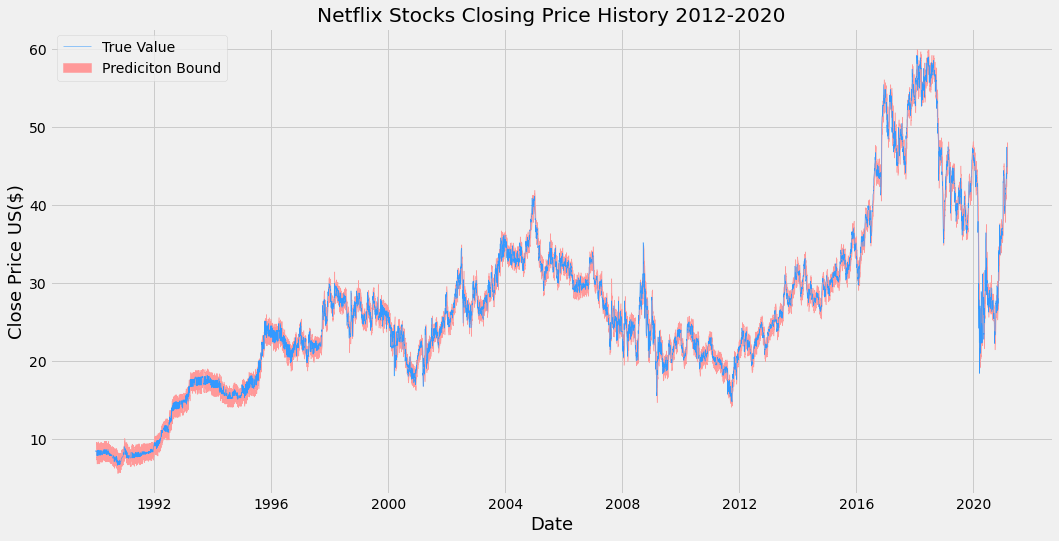

In [45]:
plt.figure(figsize=(16,8))
plt.title('Netflix Stocks Closing Price History 2012-2020')

plt.fill_between(new_df['Date'], new_df['lower'], new_df['upper'], label='Prediciton Bound', color='#FF9999', alpha=1.0)
# plt.plot(test_df['Date'],test_predictions, label='prediction', color='Blue')
plt.plot(new_df['Date'],new_df['Close'], label='True Value', color='#3399FF',linewidth=0.5)

plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price US($)',fontsize=18)
plt.legend()
plt.show()

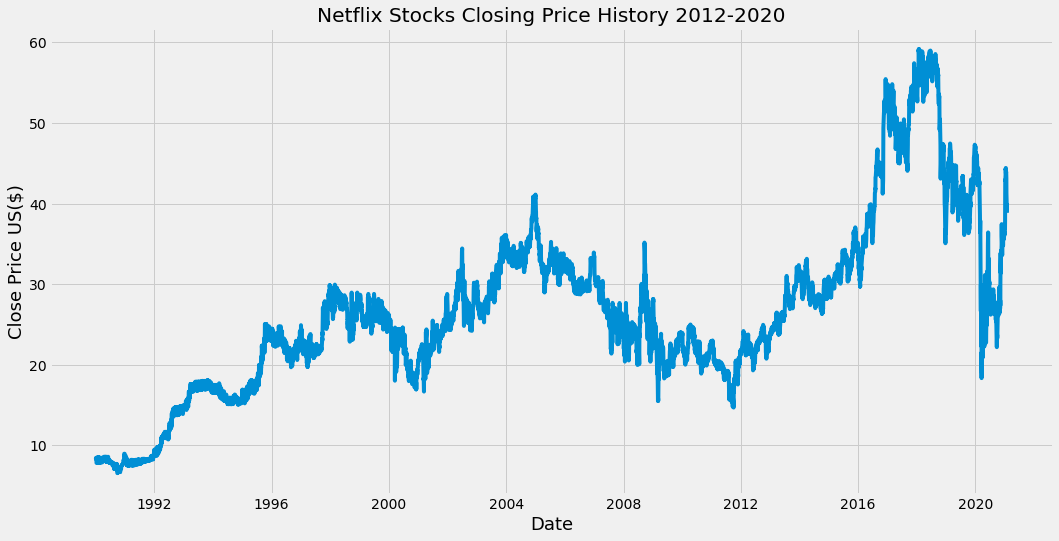

In [6]:
plt.figure(figsize=(16,8))
plt.title('Netflix Stocks Closing Price History 2012-2020')
plt.plot(new_df['Date'],new_df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price US($)',fontsize=18)
plt.style.use('fivethirtyeight')
plt.show()